In [23]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from random import randint

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [25]:
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 150
LOSS_FUNCTION = nn.MSELoss()
LOWEST_LOSS = 150000

In [26]:
y_loss = {}
y_loss['train'] = []
y_loss['test'] = []

X_epochs = []

In [27]:
def data_workflow(input_data, target_value):
    X = input_data.drop([target_value], axis=1)
    y = input_data[target_value]

    #print(X)
    #print(y)

    X = X.to_numpy()
    y = y.to_numpy()

    X = torch.from_numpy(X)
    y = torch.from_numpy(y)

    data = TensorDataset(X, y)

    train_ds, test_ds = train_test_split(data, test_size=0.2, random_state=25)

    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

    print(f"training data: {train_dl}\n test data: {test_dl}")
    return train_dl, test_dl
    



In [28]:
csv_filepath = "./final_harvest_data.csv"

data = pd.read_csv(csv_filepath)
DATA = data.drop(['date', 'index', 'plant_id', 'tray_id', 'row', 'column'], axis=1)

DATA

,LFW_g,LDW_g,LA_mm2,length_mm,width_mm,height_mm,plant_area,plant_convex_hull_area,plant_solidity,plant_perimeter,plant_width,plant_height,plant_longest_path,plant_convex_hull_vertices,plant_ellipse_major_axis,plant_ellipse_minor_axis,plant_ellipse_angle,plant_ellipse_eccentricity
0,1.30,0.078,31.95,4.3,5.2,5.8,1211,1456.0,0.831731,189.923880,49,42,346,16,45.684494,40.965988,92.878510,0.442608
1,2.10,0.148,44.10,5.3,5.7,5.5,1412,1556.5,0.907164,181.338094,56,41,370,20,53.368065,37.484673,96.255425,0.711802
2,3.36,0.196,67.61,7.3,6.5,8.9,1303,1766.5,0.737617,247.865005,49,54,333,19,46.356819,43.059174,2.102176,0.370421
3,3.07,0.184,66.98,5.8,7.6,7.5,1601,1787.0,0.895915,203.480229,44,59,395,21,55.633369,38.548523,15.127802,0.721031
4,3.17,0.187,68.74,7.2,8.0,7.1,1919,2372.0,0.809022,263.421354,62,58,454,19,60.012882,48.875011,55.774792,0.580292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,57.96,3.010,726.46,18.5,18.5,13.0,19084,22974.0,0.830678,767.938160,193,167,1367,33,190.580887,137.733093,62.138748,0.691160
161,81.46,3.880,1001.79,21.0,21.5,14.8,18373,21556.5,0.852318,661.612260,164,189,1317,29,176.040924,141.141724,22.056726,0.597653
162,140.84,6.380,1707.14,23.0,22.5,16.9,23374,26050.0,0.897274,683.754395,186,194,1427,31,191.379974,164.496170,175.959305,0.511091
163,108.17,5.250,1364.18,31.4,20.5,16.6,23457,25678.5,0.913488,671.754395,198,179,1364,31,194.815384,159.870819,122.656914,0.571464


In [29]:
LFW_train, LFW_test = data_workflow(DATA, 'LFW_g')

training data: <torch.utils.data.dataloader.DataLoader object at 0x7f92c73d0040>
 test data: <torch.utils.data.dataloader.DataLoader object at 0x7f92c7121e20>


In [30]:
class DeepNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(17, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
            
        ) 

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits.double()
        



In [31]:
model = DeepNeuralNetwork()
model = model.double()
print(model)

DeepNeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=17, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [32]:
def train_loop(dataset, model, loss_function, optimizer, filler):
    model.train()
    for (X, y) in dataset:
        #X, y = X.to('cuda'), y.to('cuda')
        y = y.view(-1,1) 
        
        model.zero_grad()
        optimizer.zero_grad()

        prediction = model(X)
        loss = loss_function(prediction, y)

        y_loss['train'].append(loss.item())
        

        loss.backward()
        optimizer.step()

        global LOWEST_LOSS
        
        print(f"Loss: {loss}")
        if (loss < LOWEST_LOSS):
            LOWEST_LOSS = loss
        #print(f"X: {X} \n Y: {y}")

In [33]:
def test_loop(dataset, model, loss_function, optimizer, filler):
    
    for (X, y) in dataset:
        #X, y = X.to('cuda'), y.to('cuda')
        y = y.view(-1,1) 
        
        model.zero_grad()
        optimizer.zero_grad()

        prediction = model(X)
        loss = loss_function(prediction, y)

        y_loss['test'].append(loss.item())
        y_loss['test'].append(loss.item())
        if (randint(0,100) < 50):
            y_loss['test'].append(loss.item())

 

        loss.backward()
        optimizer.step()

        global LOWEST_LOSS
        
        print(f"Test Loss: {loss}")
        
        #print(f"X: {X} \n Y: {y}")

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
for t in range(EPOCHS):
    print(f"Epoch {t+1}\n------------------------------------")
    train_loop(LFW_train, model, LOSS_FUNCTION, optimizer, LOWEST_LOSS)
    test_loop(LFW_test, model, LOSS_FUNCTION, optimizer, LOWEST_LOSS)
    X_epochs.append(t)
print("Training complete!")
print(LOWEST_LOSS)

Epoch 1
------------------------------------
Loss: 1711.4879924052043
Loss: 501747.07980719674
Loss: 28954.63832118937
Loss: 31116.65455842917
Loss: 145799.41497881425
Test Loss: 73287.02675679918
Test Loss: 797.5103827128048
Epoch 2
------------------------------------
Loss: 11355.929042035592
Loss: 2574.9661570387616
Loss: 500.58914448699056
Loss: 6710.133269233986
Loss: 34968.19503746668
Test Loss: 198.42323276884338
Test Loss: 1.7664515211214404
Epoch 3
------------------------------------
Loss: 6401.598192191775
Loss: 10714.484029238389
Loss: 9744.452382591795
Loss: 7695.320618955872
Loss: 3275.539951228861
Test Loss: 417.8188844753367
Test Loss: 999.9982905335027
Epoch 4
------------------------------------
Loss: 1684.4508921855304
Loss: 4208.304166888015
Loss: 2132.709536990068
Loss: 6784.584193680972
Loss: 76.87927675183187
Test Loss: 614.0917492988842
Test Loss: 0.8069246260713916
Epoch 5
------------------------------------
Loss: 1490.3553034534548
Loss: 3275.2201663759365
Lo

[1711.4879924052043, 501747.07980719674, 28954.63832118937, 31116.65455842917, 145799.41497881425, 11355.929042035592, 2574.9661570387616, 500.58914448699056, 6710.133269233986, 34968.19503746668, 6401.598192191775, 10714.484029238389, 9744.452382591795, 7695.320618955872, 3275.539951228861, 1684.4508921855304, 4208.304166888015, 2132.709536990068, 6784.584193680972, 76.87927675183187, 1490.3553034534548, 3275.2201663759365, 3386.962875456083, 1637.8689217176602, 463.8694005032329, 5176.703781302061, 4205.738727577913, 420.91428824772026, 175.00508194621514, 149.14938539386074, 1068.9073052873964, 466.15274555447274, 602.6211055280907, 295.61350327602315, 73.69530635228436, 251.56334158354497, 2939.147659828135, 269.8113970641512, 273.62810207290516, 400.51177240523293, 434.0862610778142, 572.8576091273857, 487.6936340302028, 725.0442799275309, 176.8350808648991, 830.2677475020918, 304.5293033456086, 1146.9517998058216, 210.2099358236257, 816.8860761455055, 131.31994623858523, 311.3578

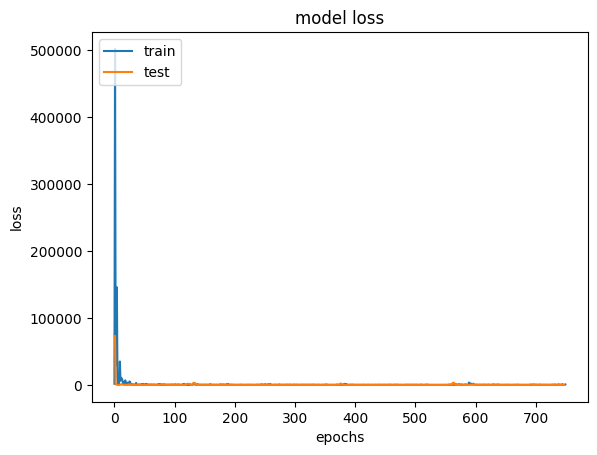

In [35]:
print(y_loss['train'])
plt.plot(y_loss['train'])
plt.plot(y_loss['test'])
#plt.plot(X_epochs)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()